# Part 1 ‐ Exploratory data analysis

In [1]:
#import libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import os
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#storing the json file as dataframe named logins
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#create a login_count columns with value 1 for all login times
logins['login_count'] = 1
logins.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [4]:
#change login_time to datetime format
logins['login_time'] = pd.to_datetime(logins['login_time'], unit='s')
logins.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [5]:
#setting index as login_time
logins.set_index('login_time', inplace=True)
logins.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
#summin the login_count in 15 minute intervals
logins_15 = logins.resample("15T").sum()
logins_15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## 15 minute interval logins

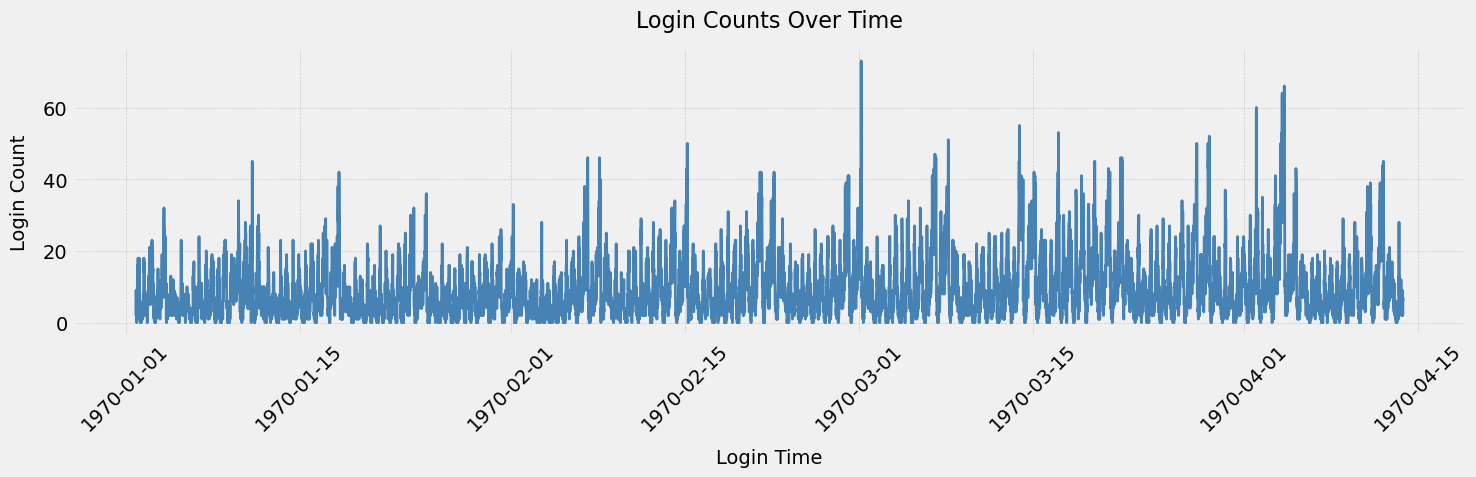

In [35]:
#Visualize the login_count with login_time
fig, ax = plt.subplots(figsize = (15,5))
plt.plot(logins_15.index, logins_15.login_count, color='steelblue', linewidth=2)
ax.set_xlabel('Login Time', fontsize=14, labelpad=10)
ax.set_ylabel('Login Count', fontsize=14, labelpad=10)
ax.set_title('Login Counts Over Time', fontsize=16, pad=15)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot above doesn't show any clear trend between the login counts and the login times, let's try some resampling to see if it helps.

## Daily login count

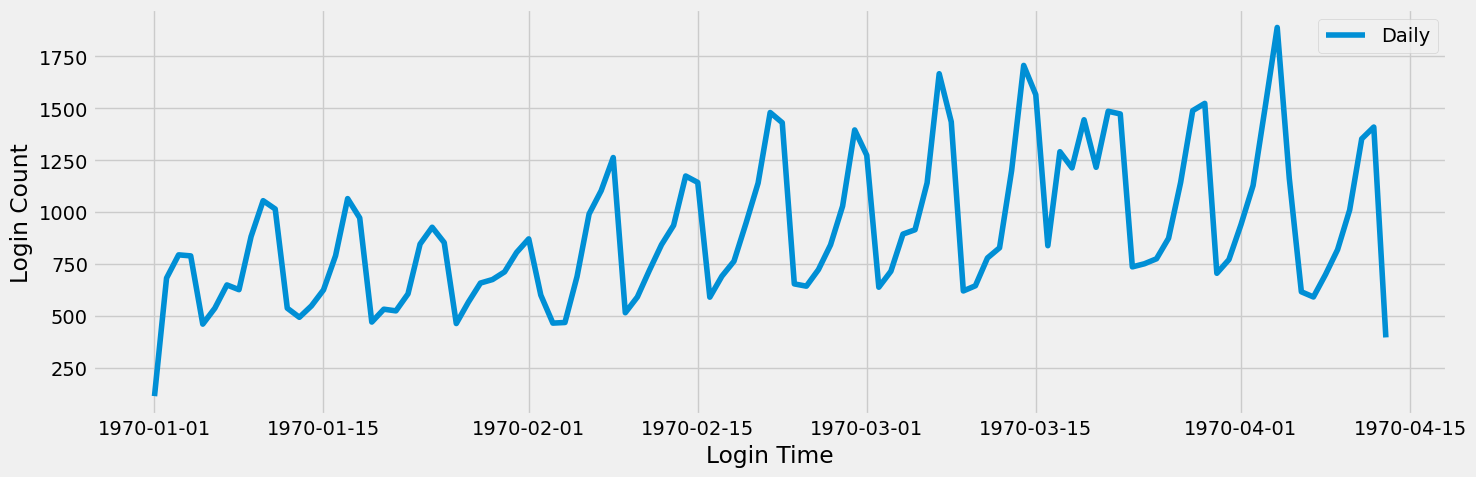

In [8]:
#resampling login_time as daily counts and visualize
daily_freq = logins_15.resample('D').sum()
fig, ax = plt.subplots(figsize = (15,5))
plt.plot(daily_freq.index, daily_freq.login_count, label='Daily')
plt.xlabel('Login Time')
plt.ylabel('Login Count')
plt.legend()
plt.tight_layout()

The daily login count shows some pattern with regularly placed peaks, let's drill down further so understand this behavior. 

## Logins grouping

In [9]:
#create a new datatframe with counts grouped with hour, day of the month and day of the week
logins_15_grouped = pd.DataFrame({'count': logins_15.login_count,
                         'hour': logins_15.index.hour,
                         'day_number': logins_15.index.day,
                         'day_of_week': logins_15.index.dayofweek}, index=logins_15.index)

logins_15_grouped.head()

,count,hour,day_number,day_of_week
login_time,,,,
1970-01-01 20:00:00,2,20,1,3
1970-01-01 20:15:00,6,20,1,3
1970-01-01 20:30:00,9,20,1,3
1970-01-01 20:45:00,7,20,1,3
1970-01-01 21:00:00,1,21,1,3


## Logins by day of the month

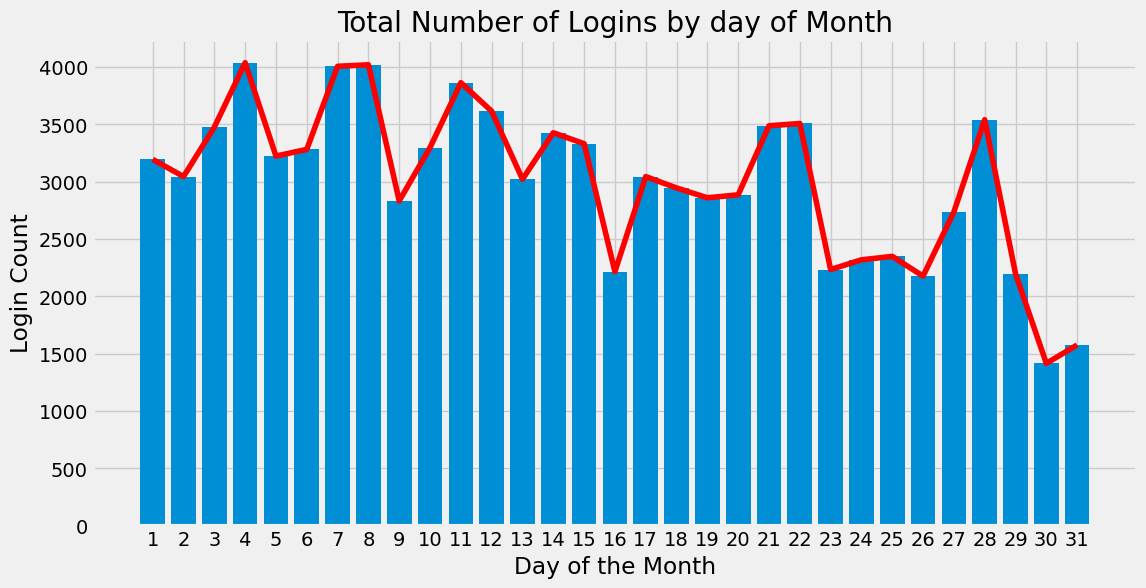

In [10]:
#visualizing logins by day of the month
logins_month_day = logins_15_grouped.groupby('day_number').sum()

plt.figure(figsize=(12,6))
plt.bar(logins_month_day.index, logins_month_day['count'])
plt.plot(logins_month_day.index, logins_month_day['count'], color='r')
plt.title('Total Number of Logins by day of Month')
plt.xlabel('Day of the Month')
plt.ylabel('Login Count')
plt.xticks(logins_month_day.index)
plt.show()

## Logins by hour of the day

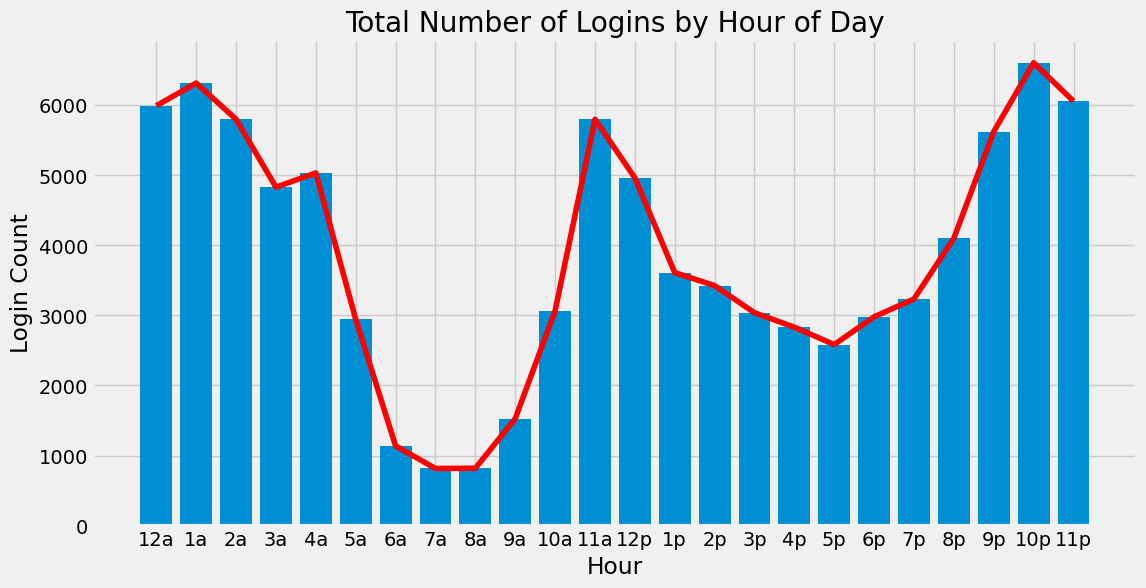

In [11]:
#visualizing logins by hour of the day
logins_hour = logins_15_grouped.groupby('hour').sum()

plt.figure(figsize=(12,6))
plt.bar(logins_hour.index, logins_hour['count'])
plt.plot(logins_hour.index, logins_hour['count'], color='r')
plt.title('Total Number of Logins by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Login Count')
plt.xticks(logins_hour.index, ['12a', '1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a',
                               '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p'])
plt.show()

Now here we observe a clear peak in the number of logins between two time intervals - 10a-12p and 8p-2a. This could indicate an increase in logins during the lunch hour and at night time when people are usually going or coming back from restaurants/pubs/bars.

## Logins by day of the week

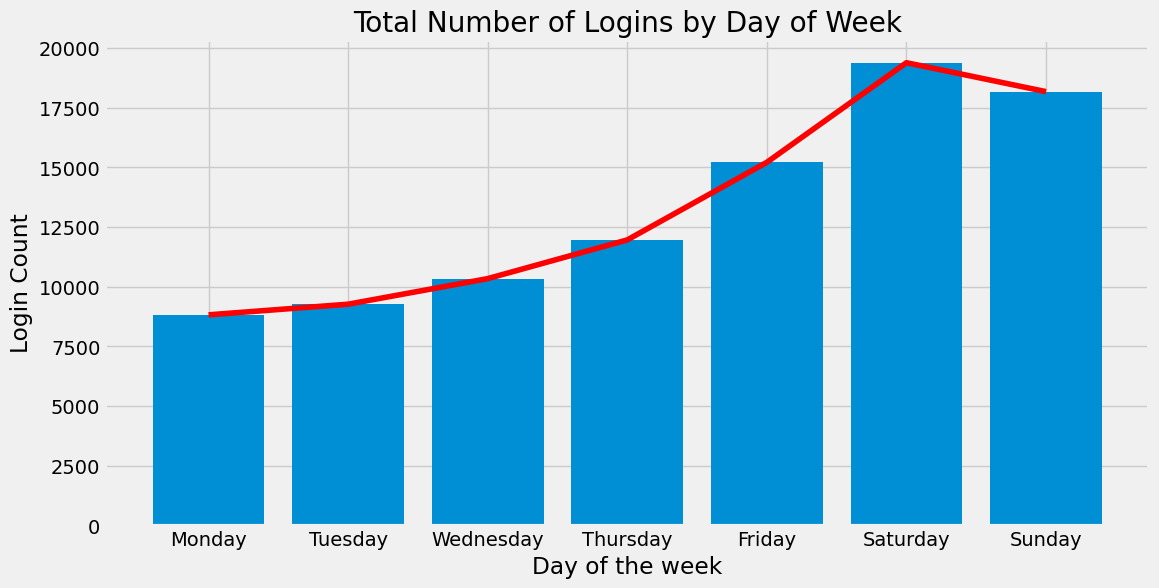

In [12]:
#visualizing logins by day of the week
logins_week_day = logins_15_grouped.groupby('day_of_week').sum()

plt.figure(figsize=(12,6))
plt.bar(logins_week_day.index, logins_week_day['count'])
plt.plot(logins_week_day.index, logins_week_day['count'], color='r')
plt.title('Total Number of Logins by Day of Week')
plt.xlabel('Day of the week')
plt.ylabel('Login Count')
plt.xticks(logins_week_day.index, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Clearly, there's an increasing trend in the number of logins as the weekend approaches.

## Logins by month

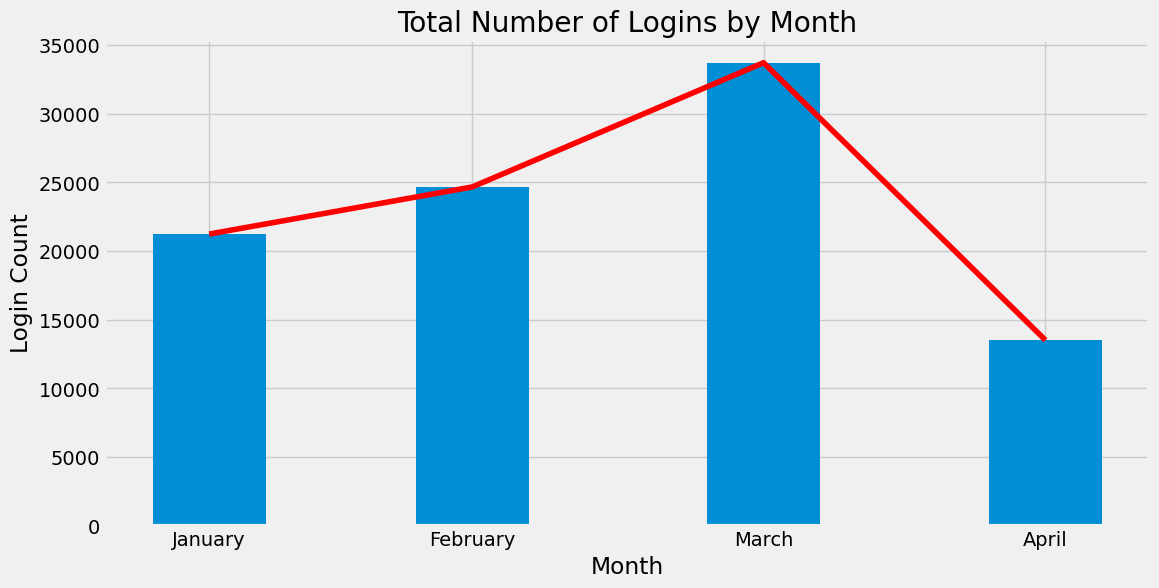

In [13]:
#visualizing logins by month
monthly_freq = logins_15.resample('M').sum()
plt.figure(figsize=(12,6))
plt.bar(monthly_freq.index, monthly_freq['login_count'], width=12)
plt.plot(monthly_freq.index, monthly_freq['login_count'], color='r')
plt.title('Total Number of Logins by Month')
plt.xlabel('Month')
plt.ylabel('Login Count')
plt.xticks(monthly_freq.index, ['January', 'February', 'March', 'April'])
plt.show()

An increase in number of logins is observed as we progress through the months, possibly due to the changing/better/warmer weather conditions. Fewer number of counts for April is due to the truncated entries.

# Part 2 ‐ Experiment and metrics design

## What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

From the limited amount of given information, my metric of choice would be number of trips per driver before and after the toll cost reimbursement policy is enforced. The fact that the upper management is inclined to perform toll cost reimbursement is most likely due to the scarcity or unequal number of drivers both in Gotham and Metropolis, and they feel they are losing out on revenue by the driver partners tending to be exclusive to each city.

##  Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
### a. how you will implement the experiment
### b. what statistical test(s) you will conduct to verify the significance of the observation
### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


The experiment would be implemented by acquiring the data for average nummber of trips per driver after the proped change and then performing permutation replicates on the original and experimental data. Hypothesis testing would be performed where the null hypothesis would be that the number of trips per driver before and after the toll is less than or equal to after the policy change. 

p-value of the hypothesis test would be calculated by dividing the the fraction of permutation replicates that are greater than or equal to the observed test statistic by the total number of samples. For example, for p-value < 0.05, the null hypothesis would be rejected and for p-value > 0.05, we would fail to reject the null hypothesis.

There are a couple of caveats here. First, the p-test itself as a value < 0.05 does not always imply a practical  significance as the total number of samples (drivers here) are going to affect this value. Another caveat is using this testing strategy we will be ignoring the fact that the drivers may be driving from one city to another chasing teh passengers while using up gas and racking up miles on their vehicles. So anotehr metric of interest would be to improve earnings per mile.

# Part 3 ‐ Predictive modeling

In [14]:
#open the json file
with open('ultimate_data_challenge.json') as f:
    user_data = json.load(f)

In [15]:
#save the json file as user_df dataframe
user_df = pd.DataFrame(user_data)
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
user_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [17]:
user_df.shape

(50000, 12)

In [18]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
#get count and percentage of missing values
missing = pd.concat([user_df.isnull().sum(), 100*user_df.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
missing.sort_values(by='count', ascending=False)

,count,percentage
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


In [20]:
#get value counts for avg_rating_of_driver
user_df['avg_rating_of_driver'].value_counts()

avg_rating_of_driver
5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
1.9        1
1.6        1
2.2        1
Name: count, dtype: int64

In [21]:
#filling missing avg_rating_of_driver by the mode
user_df['avg_rating_of_driver'] = user_df['avg_rating_of_driver'].fillna(5.0)

In [22]:
#get value counts phone
user_df['phone'].value_counts()

phone
iPhone     34582
Android    15022
Name: count, dtype: int64

In [23]:
#filling missing phone values by the mode
user_df['phone'] = user_df['phone'].fillna('iPhone')

In [24]:
#get value counts for avg_rating_by_driver
user_df['avg_rating_by_driver'].value_counts()

avg_rating_by_driver
5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: count, dtype: int64

In [25]:
#filling missing avg_rating_by_driver values by the mode
user_df['avg_rating_by_driver'] = user_df['avg_rating_by_driver'].fillna(5.0)

In [26]:
#checking null values again
user_df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [27]:
#getting value counts for city
user_df['city'].value_counts(normalize=True)

city
Winterfell        0.46672
Astapor           0.33068
King's Landing    0.20260
Name: proportion, dtype: float64

In [28]:
#getting value counts for ultimate_black_user
user_df['ultimate_black_user'].value_counts(normalize=True)

ultimate_black_user
False    0.62292
True     0.37708
Name: proportion, dtype: float64

In [29]:
#convert the two date columsn into datetime format
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])

In [30]:
# getting the max last_trip_date to be able to 30 days before that to label the user as active or otherwise
user_df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [31]:
#create a column called active and label as 1 is teh last_trip date was before 2014-06-01 else 0
user_df['active'] = np.where(user_df['last_trip_date'] >= '2014-06-01', 1, 0)

In [32]:
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [33]:
#getting the percentage of active users
user_df[user_df['active']==1]['active'].count()/user_df['active'].count()

0.37608

38% of the users were retained

## Exploratory Data Analysis

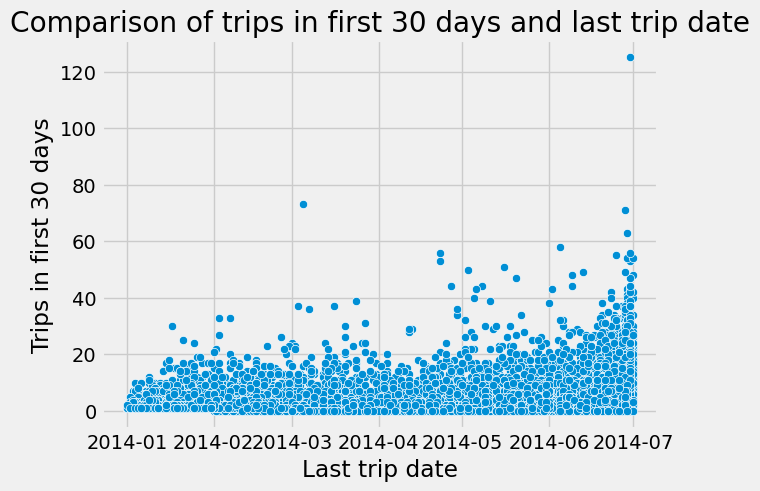

In [36]:
sns.scatterplot(x=user_df.last_trip_date, y=user_df.trips_in_first_30_days)
plt.title('Comparison of trips in first 30 days and last trip date')
plt.xlabel('Last trip date')
plt.ylabel('Trips in first 30 days')
plt.show()

There is apositive relationship between trips in first 30 days and last trip date.

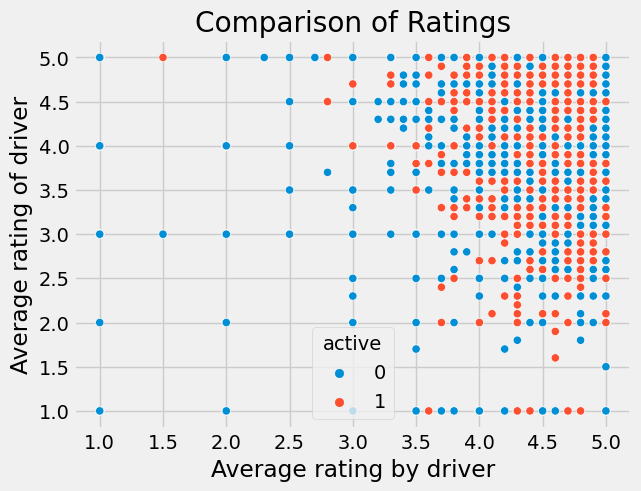

In [38]:
sns.scatterplot(x=user_df.avg_rating_by_driver, y=user_df.avg_rating_of_driver, hue=user_df.active)
plt.title('Comparison of Ratings')
plt.xlabel('Average rating by driver')
plt.ylabel('Average rating of driver')
plt.show()


most active users have been rated highly by the driver.

<Axes: xlabel='phone', ylabel='count'>

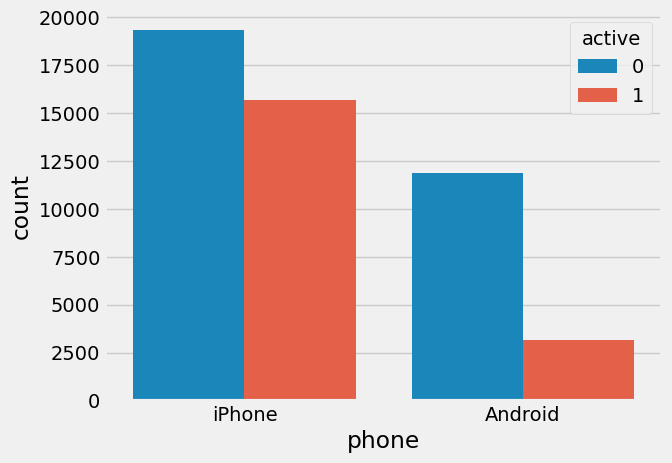

In [39]:
sns.countplot(x='phone', data=user_df, hue='active')

<Axes: xlabel='city', ylabel='count'>

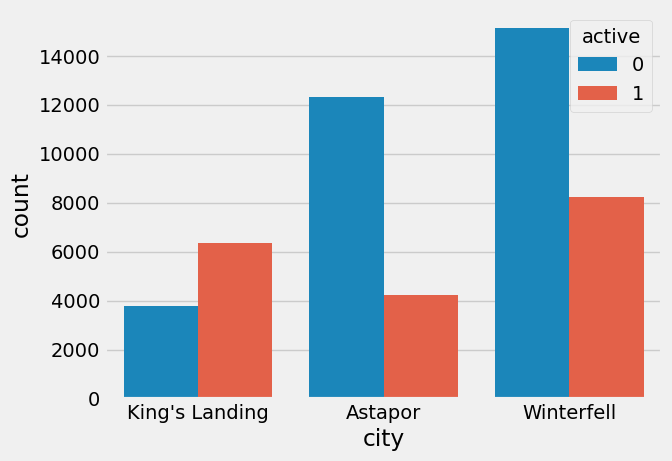

In [40]:
sns.countplot(x='city', data=user_df, hue='active')

<Axes: xlabel='ultimate_black_user', ylabel='count'>

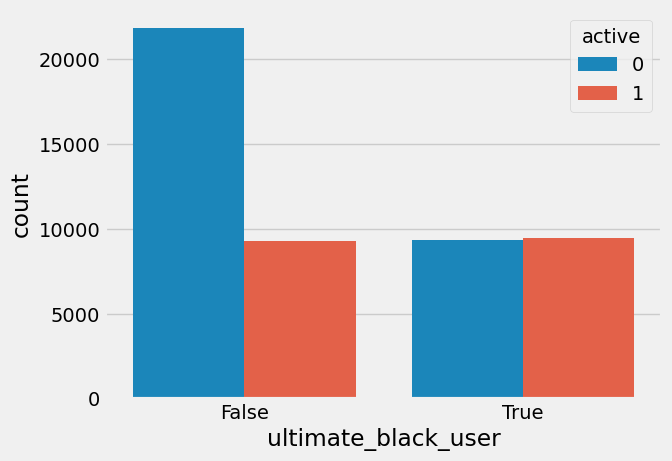

In [41]:
sns.countplot(x='ultimate_black_user', data=user_df, hue='active')

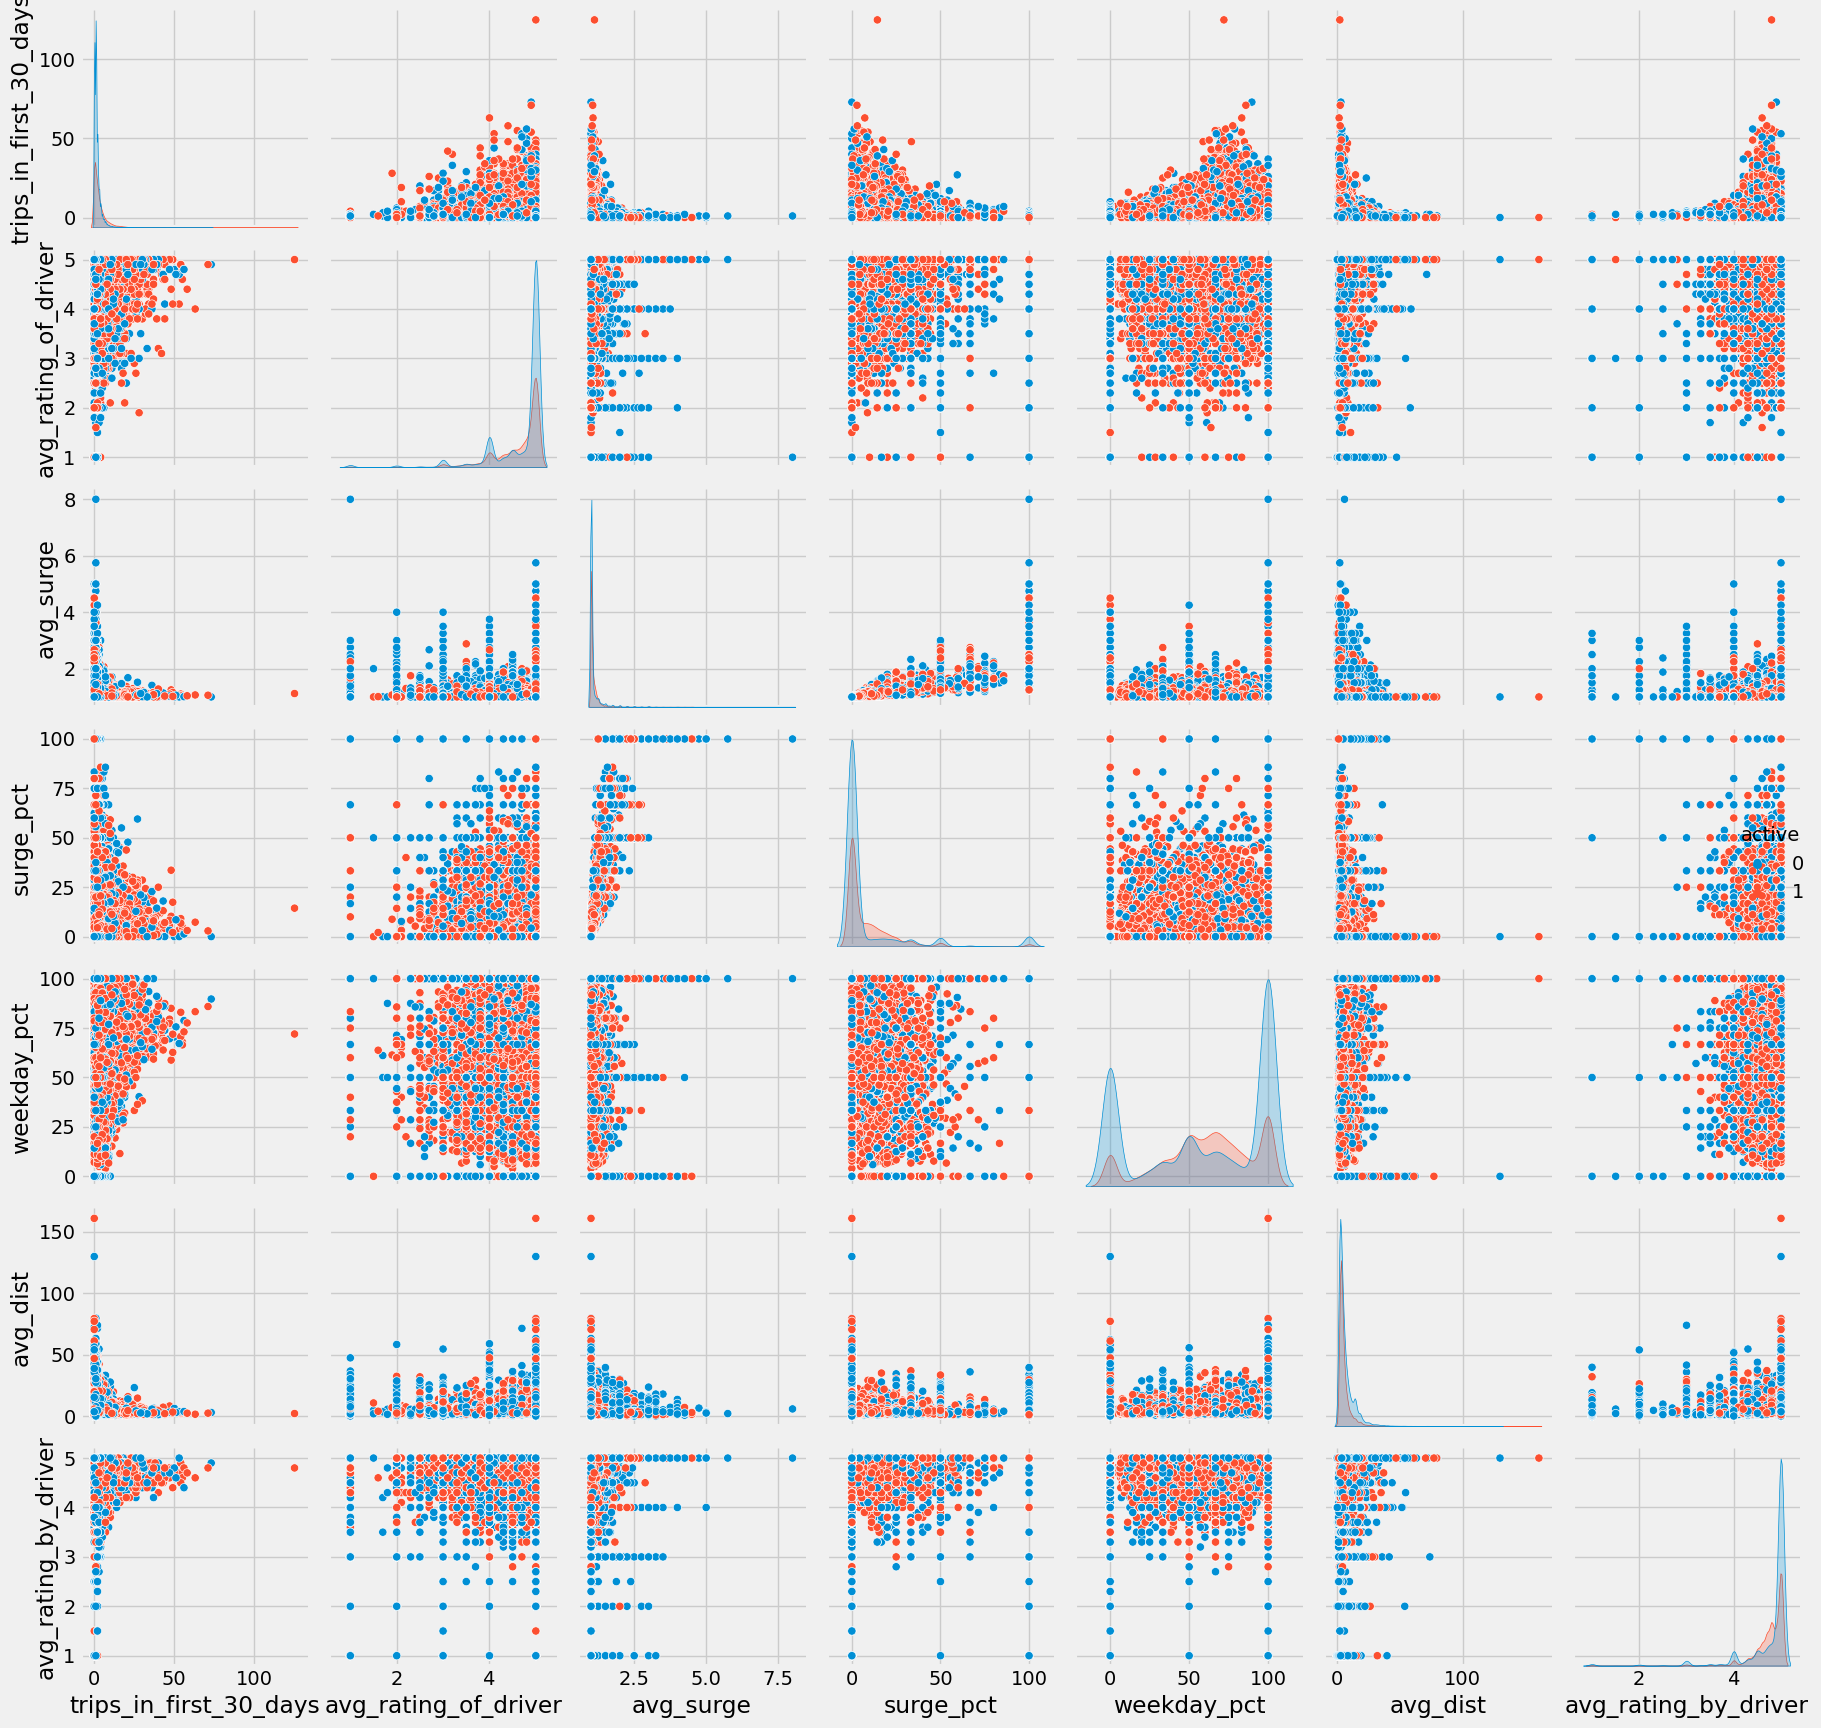

In [42]:
sns.pairplot(user_df, hue='active', vars=['trips_in_first_30_days', 'avg_rating_of_driver',
                                          'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
                                          'avg_rating_by_driver'])
plt.tight_layout()

In [43]:
user_df_grouped = user_df.groupby('active')[['trips_in_first_30_days', 'avg_rating_of_driver',
                                             'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
                                             'avg_rating_by_driver']].mean().reset_index()

In [44]:
user_df_grouped

,active,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,0,1.658482,4.689201,1.075339,8.666739,60.647032,6.207939,4.788588
1,1,3.306318,4.628260,1.073809,9.152797,61.389034,5.114788,4.763226


Active users take most trip in the first 30 days and show a higher surge pct

In [45]:
#convert categorical variable into dummy variables
user_df = pd.get_dummies(data=user_df, columns=['city', 'phone', 'ultimate_black_user'])

In [46]:
#drop sign_up date and last_trip_date
user_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [47]:
user_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,False,True,False,False,True,False,True
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,True,False,False,True,False,True,False
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,True,False,False,False,True,True,False
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,False,True,False,False,True,False,True
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,False,False,True,True,False,True,False


In [48]:
X = user_df.drop(['active'], axis=1)
y = user_df['active']

In [49]:
#splitting the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [50]:
#segregating the data into to_scale and not_to_scale
to_scale = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
            'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
not_to_scale = ['city_Astapor', "city_King's Landing", "city_Winterfell",
                'phone_Android', 'phone_iPhone', 'ultimate_black_user_False',
                'ultimate_black_user_True']

In [51]:
#scaling the training data
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(X_train[to_scale]),
                            columns=X_train[to_scale].columns).reset_index(drop=True)
X_train=pd.concat([scaled_train, X_train[not_to_scale].reset_index(drop=True)], axis=1)
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,-0.341768,0.570907,-0.335545,-0.444283,-1.643203,1.097858,0.497264,False,False,True,False,True,True,False
1,0.988171,-0.796474,0.333787,-0.229141,-1.057583,-0.122973,-0.855912,False,False,True,False,True,True,False
2,-0.341768,0.570907,-0.335545,-0.444283,1.055505,0.863487,-1.758030,False,False,True,False,True,False,True
3,-0.607755,0.570907,1.895561,2.892924,-1.643203,-0.600462,0.497264,False,True,False,True,False,True,False
4,-0.341768,-0.283706,-0.335545,-0.444283,-0.293849,-0.533998,0.497264,True,False,False,False,True,False,True


In [52]:
#scaling the test data
scaled_test = pd.DataFrame(scaler.fit_transform(X_test[to_scale]),columns=X_test[to_scale].columns).reset_index(drop=True)
X_test=pd.concat([scaled_test, X_test[not_to_scale].reset_index(drop=True)], axis=1)
X_test.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.700809,-1.499268,-0.153562,0.280747,-0.488797,-0.422080,0.269242,False,False,True,False,True,False,True
1,-0.319069,-0.462275,-0.339524,-0.439834,0.105513,-0.229726,-0.169263,False,True,False,False,True,False,True
2,-0.574038,-1.153604,-0.339524,-0.439834,-0.970161,-0.520904,-1.046274,False,False,True,False,True,True,False
3,-0.064099,-1.153604,-0.339524,-0.439834,1.046727,-0.019725,-2.142539,False,True,False,False,True,True,False
4,-0.574038,0.574719,-0.339524,-0.439834,1.046727,-0.085020,-3.896561,True,False,False,False,True,False,True


## Base Models

In [53]:
#building base logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Accuracy on training set = {}'.format(lr.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(lr.score(X_test, y_test)))

Accuracy on training set = 0.7176
Accuracy on test set = 0.7226


In [54]:
#building base random forest model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('Accuracy on training set = {}'.format(rfc.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(rfc.score(X_test, y_test)))

Accuracy on training set = 0.994175
Accuracy on test set = 0.7512


In [55]:
#building base knn model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_rfc = knn.predict(X_test)
print('Accuracy on training set = {}'.format(knn.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(knn.score(X_test, y_test)))

Accuracy on training set = 0.818775
Accuracy on test set = 0.7519


These models were chosen based on their ability to provide good results for classification.

## Hyperparameter tuning

In [58]:
#perform hyperparameter tuning on random forest
param_grid = {
    'n_estimators': [100, 300],  
    'max_depth': [5, 15],        
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 3]  
}
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 15], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [59]:
rfc_cv.best_params_

{'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [60]:
pred_rfc = rfc_cv.predict(X_test)
print(f"Accuracy:", metrics.accuracy_score(y_test, pred_rfc))
print(f"Confusion matrix: \n{metrics.confusion_matrix(y_test, pred_rfc)}")

Accuracy: 0.7805
Confusion matrix: 
[[5396  843]
 [1352 2409]]


In [61]:
#perform hyperparameter tuning on knn
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2], 'leaf_size': [10, 20, 30]}
knn_cv = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30], 'n_neighbors': [3, 5, 7],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [62]:
knn_cv.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'uniform'}

In [63]:
pred_knn = knn_cv.predict(X_test)
print(f"Accuracy:", metrics.accuracy_score(y_test, pred_knn))
print(f"Confusion matrix: \n{metrics.confusion_matrix(y_test, pred_knn)}")

Accuracy: 0.7579
Confusion matrix: 
[[5273  966]
 [1455 2306]]


## Final Model

In [64]:
rfc = RandomForestClassifier(random_state=42, max_depth=15, min_samples_leaf=5,
                             min_samples_split=2, n_estimators=500)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('Accuracy on training set = {}'.format(rfc.score(X_train, y_train)))
print('Accuracy on test set = {}'.format(rfc.score(X_test, y_test)))

Accuracy on training set = 0.838475
Accuracy on test set = 0.7824


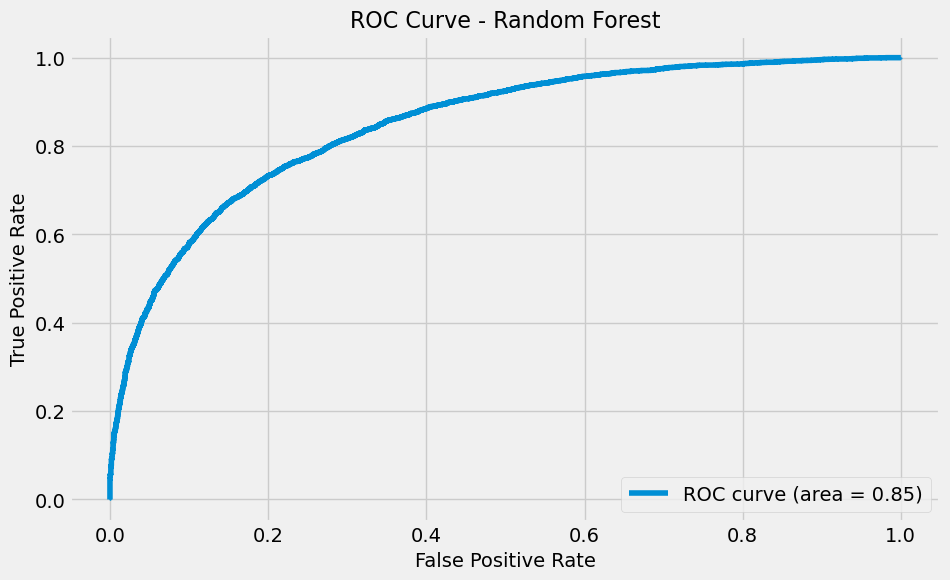

In [66]:
from sklearn.metrics import roc_curve, auc
y_predprob_rfc = rfc.predict_proba(X_test)[:,1]

fp, tp, th = roc_curve(y_test, y_predprob_rfc)
plt.figure(figsize=(10, 6))
plt.plot(fp, tp, marker='.', markersize=1, label='ROC curve (area = %0.2f)' %(auc(fp, tp)))
plt.xlabel('False Positive Rate', color='black', fontsize=14)
plt.ylabel('True Positive Rate', color='black', fontsize=14)
plt.title('ROC Curve - Random Forest', fontsize=16, color='black')
plt.legend(loc="lower right")

In [67]:
imps = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imps

avg_rating_by_driver         0.152940
weekday_pct                  0.133049
avg_dist                     0.120035
surge_pct                    0.105799
city_King's Landing          0.090481
avg_surge                    0.084024
trips_in_first_30_days       0.073462
avg_rating_of_driver         0.062297
phone_iPhone                 0.035810
phone_Android                0.035369
ultimate_black_user_False    0.031223
ultimate_black_user_True     0.029716
city_Astapor                 0.028451
city_Winterfell              0.017343
dtype: float64

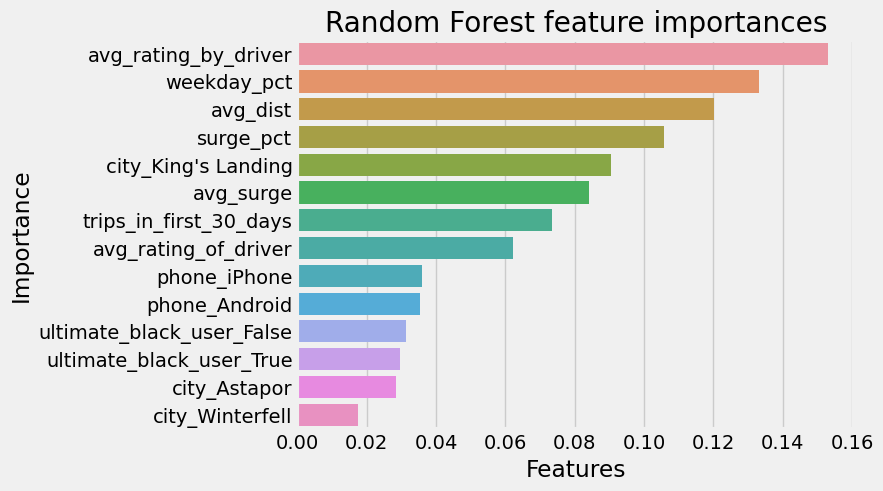

In [68]:
sns.barplot(x=imps, y=imps.index)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest feature importances')
plt.show()

Based on this model, I would provide the following recommendations to Ultimate Technologies to increase the retention of the users:
- provide discount to weekday users
- provide incentives to users for taking trips in the first 30 days
- provide discounts to users traveling long distances

The main caveat of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions. In general, these algorithms are fast to train, but quite slow to create predictions once they are trained.